In [143]:
import numpy as np
import matplotlib.pyplot as plt
import bemcs
import utilfunctions as UF
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Topographic Loading in an Elastic Medium using the Boundary Element Method

## Introduction

This notebook demonstrates:

- Building a simple 2D surface mesh representing topography.

- Computing stress and displacement kernels using `bemcs`.

- Solving for tractions due to lithostatic loading.

- Adding a localized landslide perturbation.

- Visualizing stress changes in the medium.

---

## Constructing the Surface Mesh

We generate a simple 1D surface using a logistic-shaped topography. Each segment becomes an element in the BEM mesh.


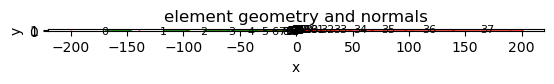

In [144]:
# construct mesh
Lscale = 200
npts = 40
hmax = 1
# xvals = np.linspace(-Lscale, Lscale, npts)
# build symmetric log-spaced x array from –Lscale → 0 → +Lscale
epsmin = 1e-3 * Lscale
half = np.logspace(np.log10(epsmin), np.log10(Lscale), (npts + 1) // 2)
xvals = np.r_[-half[::-1][:-1], half]
yvals = UF.logistic(xvals, L=hmax, k=2, x0=0)

x1 = xvals[0:-1]
x2 = xvals[1:]
y1 = yvals[0:-1]
y2 = yvals[1:]
BCtype = np.array([f"t_global" for i in range(npts - 1)])

# construct mesh
els = bemcs.initialize_els()

els.x1 = x1
els.y1 = y1
els.x2 = x2
els.y2 = y2

bemcs.standardize_els_geometry(els, reorder=False)
bemcs.plot_els_geometry(els)

## Define Material Properties

In [145]:
# Elastic parameters and lithostatic effects
mu = 1  # normalized units (mostly does not matter for topographic problem)
nu = 0.25  # Poisson's ratio
rho = 1  # rho*g/mu
ydatum = 1  # provide a datum for verticals

## Observation Grid and Compute Kernels

A rectangular grid where stresses will be evaluated.

In [146]:
# Compute displacement & stress kernels
# Observation points
n_obs = 40
xlimits = [-5, 5]
x_obs = np.linspace(xlimits[0], xlimits[1], n_obs)
y_obs = np.linspace(-2 * hmax, 1.2 * hmax, n_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# create a mask to remove all plotted values above topography (outside the domain)
index = bemcs.inpolygon(
    x_obs,
    y_obs,
    np.hstack((els.x_centers, 100, 100, -100)),
    np.hstack((els.y_centers, 10, -10, -10)),
)

In [ ]:
# provide connections to compute trapeoidal basis functions
# connectivity matrix: each row is a group of 3 consecutive elements
# connect_matrix = np.vstack(
#     [np.array([i, i + 1, i + 2]) for i in range(0, len(els.x1) - 2, 1)]
# )
# compute kernels [Nobs x 2*N_trapz]
# _, _, K_sxx, K_syy, K_sxy = bemcs.bemAssembly.get_kernels_trapezoidalforce_planestrain(
#     x_obs, y_obs, els, connect_matrix
# )

_, _, K_sxx0, K_syy0, K_sxy0 = (
    bemcs.bemAssembly.get_displacement_stress_kernel_force_planestrain(
        x_obs.flatten(),
        y_obs.flatten(),
        els.x_centers,
        els.y_centers,
        els.half_lengths,
        els.rot_mats,
        els.rot_mats_inv,
        mu,
        nu,
    )
)
# sum over basis functions (using constant basis for now)
K_sxx0 = K_sxx0[:, :, 0, :] + K_sxx0[:, :, 1, :]
K_syy0 = K_syy0[:, :, 0, :] + K_syy0[:, :, 1, :]
K_sxy0 = K_sxy0[:, :, 0, :] + K_sxy0[:, :, 1, :]
K_sxx = np.empty((K_sxx0.shape[0], 2 * K_sxx0.shape[2]))
K_sxx[:, 0::2] = K_sxx0[:, 0, :]
K_sxx[:, 1::2] = K_sxx0[:, 1, :]
K_syy = np.empty((K_syy0.shape[0], 2 * K_syy0.shape[2]))
K_syy[:, 0::2] = K_syy0[:, 0, :]
K_syy[:, 1::2] = K_syy0[:, 1, :]
K_sxy = np.empty((K_sxy0.shape[0], 2 * K_sxy0.shape[2]))
K_sxy[:, 0::2] = K_sxy0[:, 0, :]
K_sxy[:, 1::2] = K_sxy0[:, 1, :]

## Solve for Lithostatic Topographic Loading

In [148]:
# first solve topographic load problem
ydatum = 0
rhog = 1  # normalized
λ = 1  # tectonic overstress
# BCval = rhog * (els.y_centers - ydatum)
BCval = np.exp(-(els.x_centers**2) / (2 * np.pi * 1**2))
bc_x = λ * nu / (1 - nu) * BCval * els.x_normals
bc_y = BCval * els.y_normals

# solve for slip coefficients
quadratic_coefs_s, quadratic_coefs_n = UF.solve_bem_system_slip(els, bc_x, bc_y, BCtype)
# Compute stresses
_, _, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
)


# solve for force coefficients
fcoefs_s, fcoefs_n = UF.solve_bem_system_force(
    els,
    _,
    bc_x,
    bc_y,
    mu,
    nu,
)
sxx_f = K_sxx[:, 0::2] @ fcoefs_s + K_sxx[:, 1::2] @ fcoefs_n
syy_f = K_syy[:, 0::2] @ fcoefs_s + K_syy[:, 1::2] @ fcoefs_n
sxy_f = K_sxy[:, 0::2] @ fcoefs_s + K_sxy[:, 1::2] @ fcoefs_n

# compute pressure in the medium
pressure = (sxx + syy) / 2 - rho * (y_obs.reshape(-1, 1) - ydatum)
pressure_f = (sxx_f + syy_f) / 2 - rho * (y_obs.reshape(-1, 1) - ydatum)
# compute deciatoric stress
deviatoric_stress = np.sqrt(1 / 4 * ((sxx - syy) ** 2) + sxy**2)
deviatoric_stress_f = np.sqrt(1 / 4 * ((sxx_f - syy_f) ** 2) + sxy_f**2)

Number of open nodes = 2
: [array([0]), array([113])]
Number of 2-overlap nodes = 37
: [array([ 3, -2]), array([ 6, -5]), array([ 9, -8]), array([ 12, -11]), array([ 15, -14]), array([ 18, -17]), array([ 21, -20]), array([ 24, -23]), array([ 27, -26]), array([ 30, -29]), array([ 33, -32]), array([ 36, -35]), array([ 39, -38]), array([ 42, -41]), array([ 45, -44]), array([ 48, -47]), array([ 51, -50]), array([ 54, -53]), array([ 57, -56]), array([ 60, -59]), array([ 63, -62]), array([ 66, -65]), array([ 69, -68]), array([ 72, -71]), array([ 75, -74]), array([ 78, -77]), array([ 81, -80]), array([ 84, -83]), array([ 87, -86]), array([ 90, -89]), array([ 93, -92]), array([ 96, -95]), array([ 99, -98]), array([ 102, -101]), array([ 105, -104]), array([ 108, -107]), array([ 111, -110])]
Number of triple junctions = 0
: []
Linear Operator Condition Number: 129830.12732257602
Force Linear Operator Condition Number: 4.769384352689797


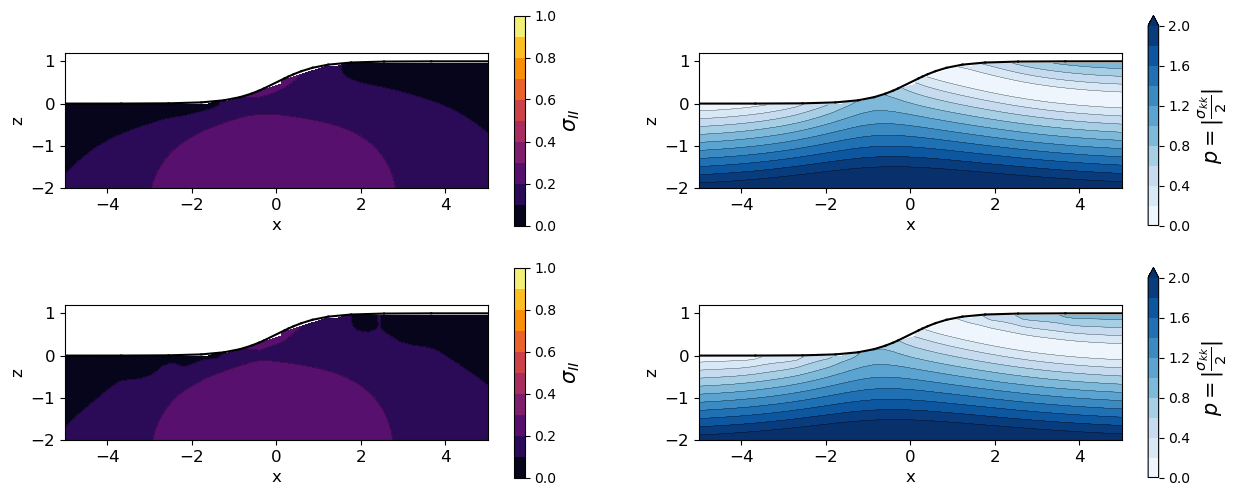

In [149]:
plt.figure(figsize=(15, 6))
# plot results using slip coefficients
plt.subplot(2, 2, 1)
# plot deviatoric stress due to topography
toplot = deviatoric_stress
toplot[~index, 0] = np.nan
toplot = toplot.reshape(n_obs, n_obs)
maxval = 1
minval = 0.0
levels = np.linspace(minval, maxval, 11)
img = plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    cmap="inferno",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
cb = plt.colorbar(img, shrink=1.0)
cb.ax.tick_params(labelsize=10)
cb.set_label("$\\sigma_{II}$", fontsize=15)
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    colors="black",
    vmin=minval,
    vmax=maxval,
    levels=levels,
    linewidths=0.2,
)
for i in range(len(els.x1)):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.xlim(xlimits)
plt.xlabel("x", fontsize=12)
plt.ylabel("z", fontsize=12)
plt.tick_params(labelsize=12)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 2, 2)
toplot = np.abs(pressure)
toplot[~index, 0] = np.nan
toplot = toplot.reshape(n_obs, n_obs)
maxval = 2
minval = 0.0
levels = np.linspace(minval, maxval, 11)
img = plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    cmap="Blues",
    vmin=minval,
    vmax=maxval,
    levels=levels,
    extend="max",
)
cb = plt.colorbar(img, shrink=1.0)
cb.ax.tick_params(labelsize=10)
cb.set_label("$p=|\\frac{\\sigma_{kk}}{2}|$", fontsize=15)
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    colors="black",
    vmin=minval,
    vmax=maxval,
    levels=levels,
    linewidths=0.2,
)
for i in range(len(els.x1)):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.xlim(xlimits)
plt.xlabel("x", fontsize=12)
plt.ylabel("z", fontsize=12)
plt.tick_params(labelsize=12)
plt.gca().set_aspect("equal", adjustable="box")

# Using force coefficients
plt.subplot(2, 2, 3)
# plot deviatoric stress due to topography
toplot = deviatoric_stress_f
toplot[~index, 0] = np.nan
toplot = toplot.reshape(n_obs, n_obs)
maxval = 1
minval = 0.0
levels = np.linspace(minval, maxval, 11)
img = plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    cmap="inferno",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
cb = plt.colorbar(img, shrink=1.0)
cb.ax.tick_params(labelsize=10)
cb.set_label("$\\sigma_{II}$", fontsize=15)
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    colors="black",
    vmin=minval,
    vmax=maxval,
    levels=levels,
    linewidths=0.2,
)
for i in range(len(els.x1)):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.xlim(xlimits)
plt.xlabel("x", fontsize=12)
plt.ylabel("z", fontsize=12)
plt.tick_params(labelsize=12)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 2, 4)
toplot = np.abs(pressure_f)
toplot[~index, 0] = np.nan
toplot = toplot.reshape(n_obs, n_obs)
maxval = 2
minval = 0.0
levels = np.linspace(minval, maxval, 11)
img = plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    cmap="Blues",
    vmin=minval,
    vmax=maxval,
    levels=levels,
    extend="max",
)
cb = plt.colorbar(img, shrink=1.0)
cb.ax.tick_params(labelsize=10)
cb.set_label("$p=|\\frac{\\sigma_{kk}}{2}|$", fontsize=15)
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    colors="black",
    vmin=minval,
    vmax=maxval,
    levels=levels,
    linewidths=0.2,
)
for i in range(len(els.x1)):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.xlim(xlimits)
plt.xlabel("x", fontsize=12)
plt.ylabel("z", fontsize=12)
plt.tick_params(labelsize=12)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

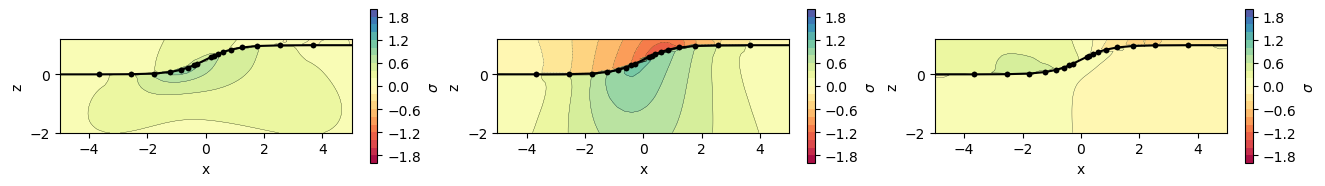

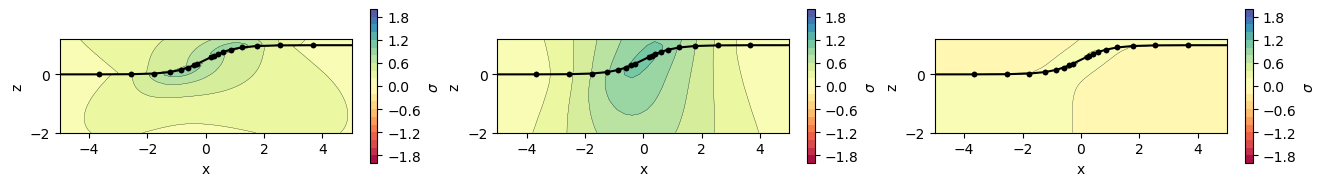

In [150]:
sxx_f = K_sxx[:, 0::2] @ fcoefs_s + K_sxx[:, 1::2] @ fcoefs_n
syy_f = K_syy[:, 0::2] @ fcoefs_s + K_syy[:, 1::2] @ fcoefs_n
sxy_f = K_sxy[:, 0::2] @ fcoefs_s + K_sxy[:, 1::2] @ fcoefs_n

plt.figure(figsize=(16, 2))
for count in range(3):
    plt.subplot(1, 3, count + 1)
    if count == 0:
        toplot = sxx_f
    elif count == 1:
        toplot = syy_f
    else:
        toplot = sxy_f
    # toplot[~index, 0] = np.nan
    toplot = toplot.reshape(n_obs, n_obs)
    maxval = 2
    minval = -maxval
    levels = np.linspace(minval, maxval, 21)
    img = plt.contourf(
        x_obs.reshape(n_obs, n_obs),
        y_obs.reshape(n_obs, n_obs),
        toplot,
        cmap="Spectral",
        vmin=minval,
        vmax=maxval,
        levels=levels,
    )
    cb = plt.colorbar(img, shrink=1.0)
    cb.ax.tick_params(labelsize=10)
    cb.set_label("$\\sigma$", fontsize=10)
    plt.contour(
        x_obs.reshape(n_obs, n_obs),
        y_obs.reshape(n_obs, n_obs),
        toplot,
        colors="black",
        vmin=minval,
        vmax=maxval,
        levels=levels,
        linewidths=0.2,
    )
    for i in range(len(els.x1)):
        plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
    plt.xlim(xlimits)
    plt.xlabel("x", fontsize=10)
    plt.ylabel("z", fontsize=10)
    plt.tick_params(labelsize=10)
    plt.gca().set_aspect("equal", adjustable="box")

# now plot stress components using slip coefficients
_, _, sxx_f, syy_f, sxy_f = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
)
# sxx_f = kernels_s[0] @ quadratic_coefs_s + kernels_n[0] @ quadratic_coefs_n
# syy_f = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
# sxy_f = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n

plt.figure(figsize=(16, 2))
for count in range(3):
    plt.subplot(1, 3, count + 1)
    if count == 0:
        toplot = sxx_f
    elif count == 1:
        toplot = syy_f
    else:
        toplot = sxy_f
    # toplot[~index, 0] = np.nan
    toplot = toplot.reshape(n_obs, n_obs)
    img = plt.contourf(
        x_obs.reshape(n_obs, n_obs),
        y_obs.reshape(n_obs, n_obs),
        toplot,
        cmap="Spectral",
        vmin=minval,
        vmax=maxval,
        levels=levels,
    )
    cb = plt.colorbar(img, shrink=1.0)
    cb.ax.tick_params(labelsize=10)
    cb.set_label("$\\sigma$", fontsize=10)
    plt.contour(
        x_obs.reshape(n_obs, n_obs),
        y_obs.reshape(n_obs, n_obs),
        toplot,
        colors="black",
        vmin=minval,
        vmax=maxval,
        levels=levels,
        linewidths=0.2,
    )
    for i in range(len(els.x1)):
        plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
    plt.xlim(xlimits)
    plt.xlabel("x", fontsize=10)
    plt.ylabel("z", fontsize=10)
    plt.tick_params(labelsize=10)
    plt.gca().set_aspect("equal", adjustable="box")

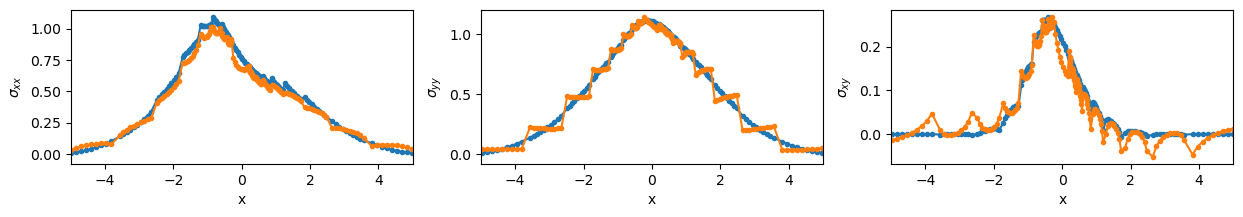

'# plot traction components\nplt.figure(figsize=(10, 2))\nplt.subplot(1, 2, 1)\nplt.plot(x_obs, sxx.flatten() * els.x_normals + sxy.flatten() * els.y_normals, "o-")\nplt.plot(x_obs, sxx_f.flatten() * els.x_normals + sxy_f.flatten() * els.y_normals, ".-")\nplt.xlabel("x", fontsize=10)\nplt.ylabel("$\\tau_x$", fontsize=10)\nplt.xlim(xlimits)\nplt.subplot(1, 2, 2)\nplt.plot(x_obs, sxy.flatten() * els.x_normals + syy.flatten() * els.y_normals, "o-")\nplt.plot(x_obs, sxy_f.flatten() * els.x_normals + syy_f.flatten() * els.y_normals, ".-")\nplt.xlabel("x", fontsize=10)\nplt.ylabel("$\\tau_y$", fontsize=10)\nplt.xlim(xlimits)\nplt.show()'

In [151]:
# evaluate stress fields at the surface
npts_per_elt = 10
dr = -1e-9  # small offset to avoid discontinuity
# x_obs = els.x_centers + els.x_normals * dr
# y_obs = els.y_centers + els.y_normals * dr
x_obs = np.zeros((len(els.x1) * npts_per_elt,))
y_obs = np.zeros((len(els.x1) * npts_per_elt,))
for i in range(len(els.x1)):
    xpts = np.linspace(els.x1[i], els.x2[i], npts_per_elt + 2)[1:-1]
    ypts = np.linspace(els.y1[i], els.y2[i], npts_per_elt + 2)[1:-1]
    x_obs[i * npts_per_elt : (i + 1) * npts_per_elt] = xpts + els.x_normals[i] * dr
    y_obs[i * npts_per_elt : (i + 1) * npts_per_elt] = ypts + els.y_normals[i] * dr

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")
# Compute stresses
_, _, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
)
# compute kernels [Nobs x 2*N_trapz]
_, _, K_sxx0, K_syy0, K_sxy0 = (
    bemcs.bemAssembly.get_displacement_stress_kernel_force_planestrain(
        x_obs.flatten(),
        y_obs.flatten(),
        els.x_centers,
        els.y_centers,
        els.half_lengths,
        els.rot_mats,
        els.rot_mats_inv,
        mu,
        nu,
    )
)
# sum over basis functions (using constant basis for now)
K_sxx0 = K_sxx0[:, :, 0, :] + K_sxx0[:, :, 1, :]
K_syy0 = K_syy0[:, :, 0, :] + K_syy0[:, :, 1, :]
K_sxy0 = K_sxy0[:, :, 0, :] + K_sxy0[:, :, 1, :]
K_sxx = np.empty((K_sxx0.shape[0], 2 * K_sxx0.shape[2]))
K_sxx[:, 0::2] = K_sxx0[:, 0, :]
K_sxx[:, 1::2] = K_sxx0[:, 1, :]
K_syy = np.empty((K_syy0.shape[0], 2 * K_syy0.shape[2]))
K_syy[:, 0::2] = K_syy0[:, 0, :]
K_syy[:, 1::2] = K_syy0[:, 1, :]
K_sxy = np.empty((K_sxy0.shape[0], 2 * K_sxy0.shape[2]))
K_sxy[:, 0::2] = K_sxy0[:, 0, :]
K_sxy[:, 1::2] = K_sxy0[:, 1, :]
sxx_f = K_sxx[:, 0::2] @ fcoefs_s + K_sxx[:, 1::2] @ fcoefs_n
syy_f = K_syy[:, 0::2] @ fcoefs_s + K_syy[:, 1::2] @ fcoefs_n
sxy_f = K_sxy[:, 0::2] @ fcoefs_s + K_sxy[:, 1::2] @ fcoefs_n

plt.figure(figsize=(15, 2))
plt.subplot(1, 3, 1)
plt.plot(x_obs, sxx, ".-")
plt.plot(x_obs, sxx_f, ".-")
plt.xlabel("x", fontsize=10)
plt.ylabel("$\\sigma_{xx}$", fontsize=10)
plt.xlim(xlimits)
plt.subplot(1, 3, 2)
plt.plot(x_obs, syy, ".-")
plt.plot(x_obs, syy_f, ".-")
# plt.plot(x_obs, rhog * (y_obs - ydatum), "k-")
plt.xlabel("x", fontsize=10)
plt.ylabel("$\\sigma_{yy}$", fontsize=10)
plt.xlim(xlimits)
plt.subplot(1, 3, 3)
plt.plot(x_obs, sxy, ".-")
plt.plot(x_obs, sxy_f, ".-")
plt.xlabel("x", fontsize=10)
plt.ylabel("$\\sigma_{xy}$", fontsize=10)
plt.xlim(xlimits)
plt.show()

"""# plot traction components
plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1)
plt.plot(x_obs, sxx.flatten() * els.x_normals + sxy.flatten() * els.y_normals, "o-")
plt.plot(x_obs, sxx_f.flatten() * els.x_normals + sxy_f.flatten() * els.y_normals, ".-")
plt.xlabel("x", fontsize=10)
plt.ylabel("$\\tau_x$", fontsize=10)
plt.xlim(xlimits)
plt.subplot(1, 2, 2)
plt.plot(x_obs, sxy.flatten() * els.x_normals + syy.flatten() * els.y_normals, "o-")
plt.plot(x_obs, sxy_f.flatten() * els.x_normals + syy_f.flatten() * els.y_normals, ".-")
plt.xlabel("x", fontsize=10)
plt.ylabel("$\\tau_y$", fontsize=10)
plt.xlim(xlimits)
plt.show()"""